# Autoencoder para classificação
Com autoencoder também conseguimos fazer classificação, que nesse caso é conhecido como detecção de anomalia. A vantagem de se utilizar o autoencoder para essa tarefa é que podemos treinar com dados de uma única amostra, util em situações em que nosso sistema majoritariamente gera um unico tipo de amostra, por exemplo: peças boas em uma linha de produção. Tudo que diferir do padrão aprendido pelo autoencoder será considerado uma anomalia, dessa forma com o autoencoder teremos um modelo de classificação binária: Imagens dentro do padrão e imagens anomalas.

Vantagens:
* Por se tratar de autoencoder temos a caracteristica de treinamento não supervisionado o que implica que não precisamos classificar nossos dados, apenas coletar as amostras dentro do padrão esperado.
* Além de detectar imagens anomalas, com autoencoder podemos rastrear na imagem a região da imagem que gerou a anomalia

Desvantagens:
* Performance inferior em relação ao treinamento supervisionado
* Apenas funciona para classificação binária
* Modelos mais complexos com maior tempo de inferencia (Encoder + Decoder)
* Se usarmos autoencoder para classificação binária porque não temos amostras de outra classe, como validar e confiar o modelo para produção?

In [1]:
import cv2
import numpy as np
from imutils import paths
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from matplotlib import pyplot as plt
from tqdm import tqdm

## BatchGenerator
Para esse exemplo iremos utilizar um dataset que foi gerado durante a fase de desenvolvimento do MVP. Com o uso do BatchGenerator não iremos precisar carregar todas as imagens na memória e realizar nosso pre processamento em tempo de execução.

In [2]:
class BatchGenerator(Sequence):
    def __init__(self, path, batch_size, image_size=(28, 28), gray_scale=True):
        self._batch_size = batch_size
        self._images_path = list(paths.list_images(path))[:300]  # para fins de exemplo vamos utilziar apenas 300 imagens
        self._image_size = image_size
        self._gray_scale = gray_scale

    def __len__(self):
        return int(np.ceil(len(self._images_path) / self._batch_size))

    def __getitem__(self, idx):
        l_bound = idx * self._batch_size
        r_bound = (idx + 1) * self._batch_size

        if r_bound > len(self._images_path):
            r_bound = len(self._images_path)
            l_bound = r_bound - self._batch_size

        instance_count = 0
        x_batch = np.zeros((r_bound - l_bound, self._image_size[1], self._image_size[0], 1 if self._gray_scale else 3))

        for instance_count, train_instance in enumerate(self._images_path[l_bound:r_bound]):
            image = cv2.imread(train_instance)
            image = cv2.resize(image, self._image_size)
            if self._gray_scale:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = image[..., np.newaxis]
            image = image / 255
            x_batch[instance_count] = image

        return x_batch, x_batch

    def on_epoch_end(self):
        np.random.shuffle(self._images_path)

#### Instanciar os generator
generator para treino e validação

In [3]:
train_generator = BatchGenerator("screw_dataset/train/wo_screw", 8)
val_generator = BatchGenerator("screw_dataset/train/wo_screw", 8)

## Criação do autoencoder

In [4]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # output (4, 4, 8)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#### Callback para salvar os modelos com o melhor loss

In [5]:
MODEL_NAME = "anomaly_detector"
best_loss_model_name = f"{MODEL_NAME}_best_loss.h5"
check_point_saver_best_loss = ModelCheckpoint(best_loss_model_name, monitor='val_loss', verbose=1,
                                              save_best_only=True, save_weights_only=False, mode='auto',
                                              period=1)

###### Treino

In [6]:
autoencoder.fit(train_generator, validation_data=val_generator, epochs=200, callbacks=[check_point_saver_best_loss])

Epoch 1/200
38/38 [==============================] - 3s 66ms/step - loss: 0.6674 - val_loss: 0.6336

Epoch 00001: val_loss improved from inf to 0.63357, saving model to anomaly_detector_best_loss.h5
Epoch 2/200
38/38 [==============================] - 1s 21ms/step - loss: 0.6273 - val_loss: 0.6143

Epoch 00002: val_loss improved from 0.63357 to 0.61430, saving model to anomaly_detector_best_loss.h5
Epoch 3/200
38/38 [==============================] - 1s 21ms/step - loss: 0.6117 - val_loss: 0.5991

Epoch 00003: val_loss improved from 0.61430 to 0.59908, saving model to anomaly_detector_best_loss.h5
Epoch 4/200
38/38 [==============================] - 1s 22ms/step - loss: 0.5970 - val_loss: 0.5957

Epoch 00004: val_loss improved from 0.59908 to 0.59568, saving model to anomaly_detector_best_loss.h5
Epoch 5/200
38/38 [==============================] - 1s 22ms/step - loss: 0.5943 - val_loss: 0.5858

Epoch 00005: val_loss improved from 0.59568 to 0.58583, saving model to anomaly_detector_be


Epoch 00043: val_loss did not improve from 0.54954
Epoch 44/200
38/38 [==============================] - 1s 27ms/step - loss: 0.5494 - val_loss: 0.5495

Epoch 00044: val_loss improved from 0.54954 to 0.54948, saving model to anomaly_detector_best_loss.h5
Epoch 45/200
38/38 [==============================] - 1s 29ms/step - loss: 0.5404 - val_loss: 0.5505

Epoch 00045: val_loss did not improve from 0.54948
Epoch 46/200
38/38 [==============================] - 1s 27ms/step - loss: 0.5482 - val_loss: 0.5494

Epoch 00046: val_loss improved from 0.54948 to 0.54937, saving model to anomaly_detector_best_loss.h5
Epoch 47/200
38/38 [==============================] - 1s 27ms/step - loss: 0.5558 - val_loss: 0.5490

Epoch 00047: val_loss improved from 0.54937 to 0.54899, saving model to anomaly_detector_best_loss.h5
Epoch 48/200
38/38 [==============================] - 1s 28ms/step - loss: 0.5512 - val_loss: 0.5490

Epoch 00048: val_loss improved from 0.54899 to 0.54896, saving model to anomaly_d


Epoch 00092: val_loss did not improve from 0.54435
Epoch 93/200
38/38 [==============================] - 1s 29ms/step - loss: 0.5405 - val_loss: 0.5460

Epoch 00093: val_loss did not improve from 0.54435
Epoch 94/200
38/38 [==============================] - 1s 28ms/step - loss: 0.5447 - val_loss: 0.5464

Epoch 00094: val_loss did not improve from 0.54435
Epoch 95/200
38/38 [==============================] - 1s 29ms/step - loss: 0.5454 - val_loss: 0.5443

Epoch 00095: val_loss improved from 0.54435 to 0.54433, saving model to anomaly_detector_best_loss.h5
Epoch 96/200
38/38 [==============================] - 1s 28ms/step - loss: 0.5440 - val_loss: 0.5445

Epoch 00096: val_loss did not improve from 0.54433
Epoch 97/200
38/38 [==============================] - 1s 29ms/step - loss: 0.5459 - val_loss: 0.5446

Epoch 00097: val_loss did not improve from 0.54433
Epoch 98/200
38/38 [==============================] - 1s 29ms/step - loss: 0.5449 - val_loss: 0.5448

Epoch 00098: val_loss did not 

38/38 [==============================] - 1s 28ms/step - loss: 0.5449 - val_loss: 0.5432

Epoch 00143: val_loss did not improve from 0.54295
Epoch 144/200
38/38 [==============================] - 1s 29ms/step - loss: 0.5434 - val_loss: 0.5433

Epoch 00144: val_loss did not improve from 0.54295
Epoch 145/200
38/38 [==============================] - 1s 28ms/step - loss: 0.5477 - val_loss: 0.5450

Epoch 00145: val_loss did not improve from 0.54295
Epoch 146/200
38/38 [==============================] - 1s 28ms/step - loss: 0.5419 - val_loss: 0.5425

Epoch 00146: val_loss improved from 0.54295 to 0.54250, saving model to anomaly_detector_best_loss.h5
Epoch 147/200
38/38 [==============================] - 1s 29ms/step - loss: 0.5445 - val_loss: 0.5433

Epoch 00147: val_loss did not improve from 0.54250
Epoch 148/200
38/38 [==============================] - 1s 29ms/step - loss: 0.5488 - val_loss: 0.5429

Epoch 00148: val_loss did not improve from 0.54250
Epoch 149/200
38/38 [==================


Epoch 00194: val_loss did not improve from 0.54163
Epoch 195/200
38/38 [==============================] - 1s 29ms/step - loss: 0.5429 - val_loss: 0.5426

Epoch 00195: val_loss did not improve from 0.54163
Epoch 196/200
38/38 [==============================] - 1s 31ms/step - loss: 0.5475 - val_loss: 0.5419

Epoch 00196: val_loss did not improve from 0.54163
Epoch 197/200
38/38 [==============================] - 1s 28ms/step - loss: 0.5462 - val_loss: 0.5423

Epoch 00197: val_loss did not improve from 0.54163
Epoch 198/200
38/38 [==============================] - 1s 28ms/step - loss: 0.5377 - val_loss: 0.5424

Epoch 00198: val_loss did not improve from 0.54163
Epoch 199/200
38/38 [==============================] - 1s 28ms/step - loss: 0.5477 - val_loss: 0.5427

Epoch 00199: val_loss did not improve from 0.54163
Epoch 200/200
38/38 [==============================] - 1s 29ms/step - loss: 0.5387 - val_loss: 0.5424

Epoch 00200: val_loss did not improve from 0.54163


# Validação

In [7]:
autoencoder = load_model(best_loss_model_name)

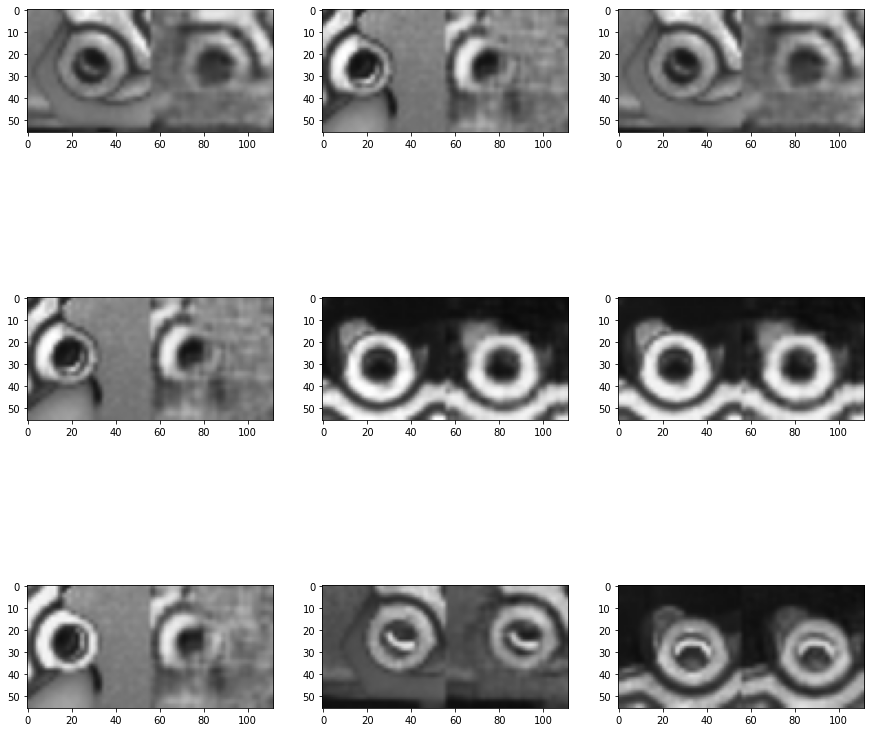

In [8]:
plt.figure(figsize=(15,15))
test_generator = BatchGenerator("screw_dataset/val/wo_screw", 9)

# batch = next(test_generator)
batch = next(iter(test_generator))[0]

preds = autoencoder.predict(batch)
for i, (gt, pred) in enumerate(zip(batch, preds)):
    plt.subplot(3,3,i+1)
    
    gt = np.uint8(gt * 255)
    pred = np.uint8(pred * 255)
    concat = cv2.hconcat([gt, pred])
    concat = cv2.resize(concat, None, fx=2, fy=2)
    plt.imshow(cv2.cvtColor(concat, cv2.COLOR_GRAY2RGB))
plt.show()

## Exercicio
Observe a geração de imagens pelo autoencoder em imagens que estão fora do padrão (imagens com parafusos), como ficou as imagens geradas?

Compare as imagens de entrada vs de saída e crie uma métrica para classificar as anomalias

In [12]:
def calc_mse(generator):
    mse = []
    for sample, _ in tqdm(generator):
        pred = autoencoder.predict(sample)

        se = pred - sample
        se = se ** 2
        se = se.sum()
        mse.append(se)
    mse = np.asarray(mse)
    return mse.mean(), mse.std()

true_generator = BatchGenerator("screw_dataset/val/wo_screw", 1)
anomaly_generator = BatchGenerator("screw_dataset/val/torx", 1)
print(calc_mse(true_generator))
print(calc_mse(anomaly_generator))

  1%|█                                                                                 | 4/300 [00:00<00:08, 33.60it/s]

(3.0857738471943956, 1.2323900687848528)


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 33.01it/s]

(21.337936889850845, 4.1187991689449595)


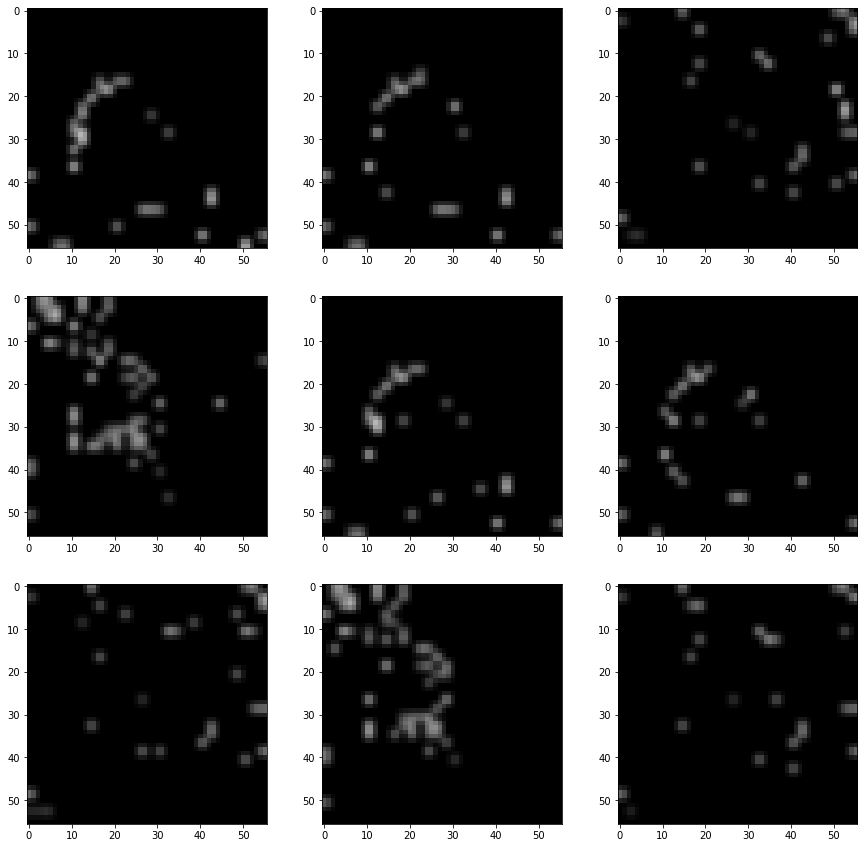

In [10]:
plt.figure(figsize=(15,15))
test_generator = BatchGenerator("screw_dataset/train/wo_screw", 9)

# batch = next(test_generator)
batch = next(iter(test_generator))[0]

preds = autoencoder.predict(batch)
for i, (gt, pred) in enumerate(zip(batch, preds)):
    plt.subplot(3,3,i+1)
    
    gt = gt[..., 0]
    pred = pred[..., 0]
    error = abs(gt - pred)
    error = error > 0.17
    error = np.uint8(error * 255)
    
    pred = np.uint8(pred * 255)
    pred = cv2.bitwise_and(pred, error)
    pred = cv2.resize(pred, None, fx=2, fy=2)
    plt.imshow(cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB))
plt.show()